In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import statistics

In [3]:
# Fungsi Plot Gambar di Jupiter
def plot_images(*imgs, figsize=(30,20), hide_ticks=False):
    f = plt.figure(figsize=figsize)
    width = np.ceil(np.sqrt(len(imgs)))
    height = np.ceil(len(imgs) / width)
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(int(height), int(width), i)
        if hide_ticks:
            ax.axis('off')
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
# Fungsi Hamming Distance
def hamming_distance(vector1, vector2):
    # Pastikan kedua vektor memiliki panjang yang sama
    assert len(vector1) == len(vector2), "Panjang vektor harus sama"

    # Hitung Hamming distance
    distance = sum(bit1 != bit2 for bit1, bit2 in zip(vector1, vector2))
    
    return distance

In [5]:
def jarak(vector1, vector2):
    return ((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2)**0.5

[50.0, 40.0, 20.0, 60.0]


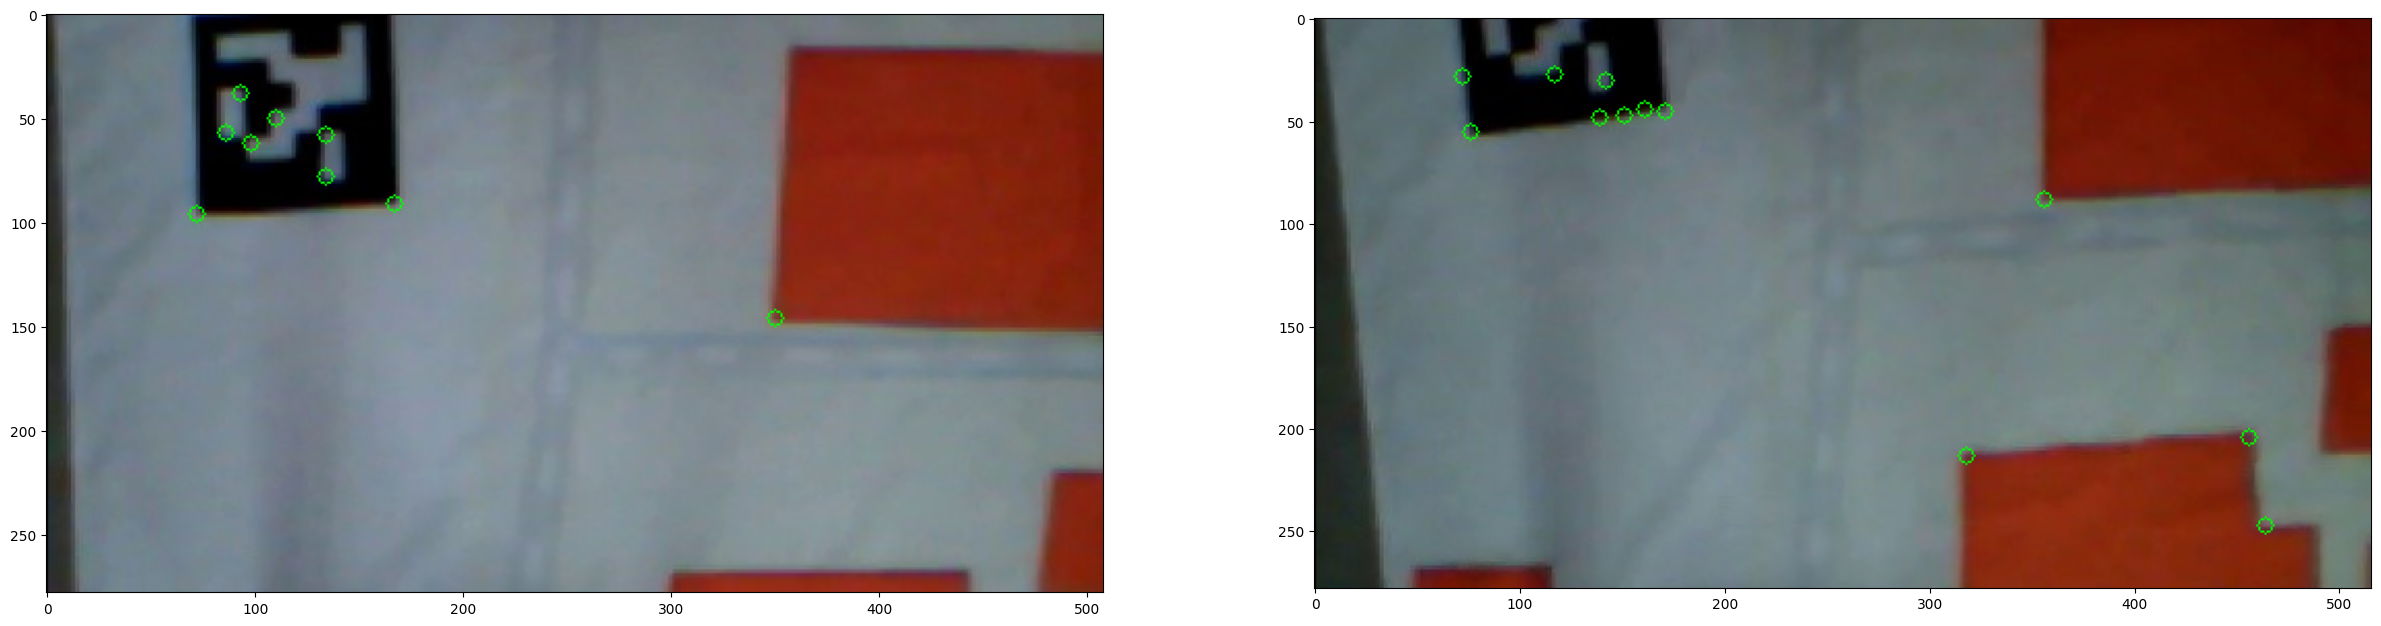

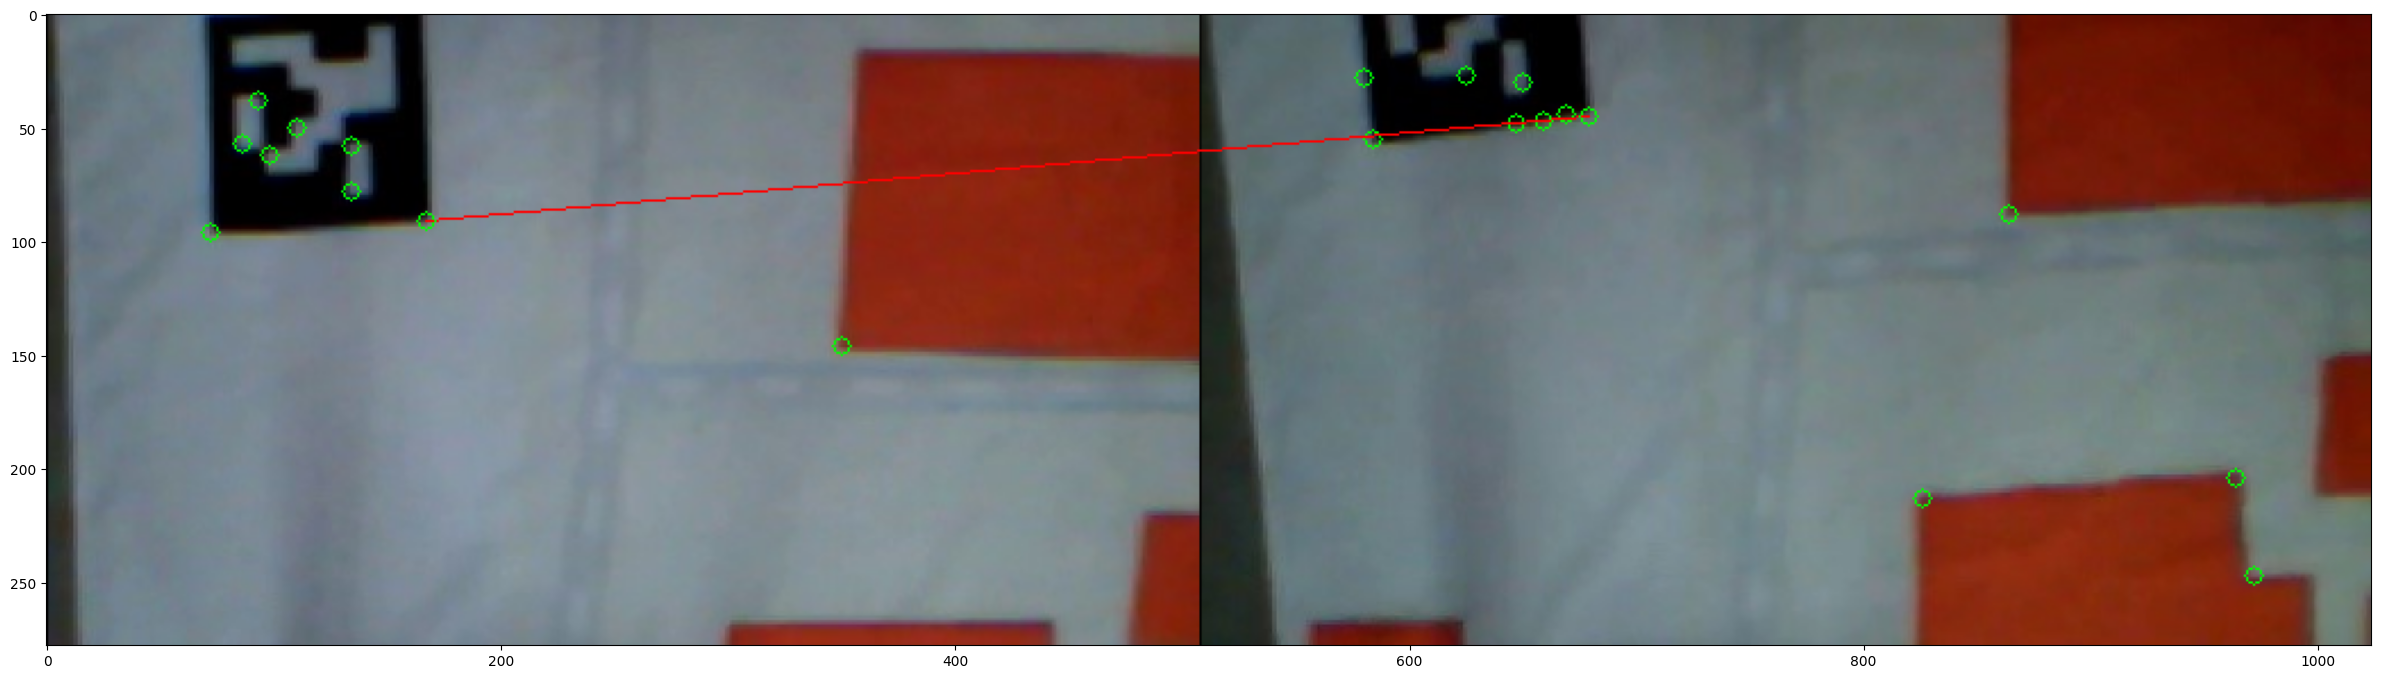

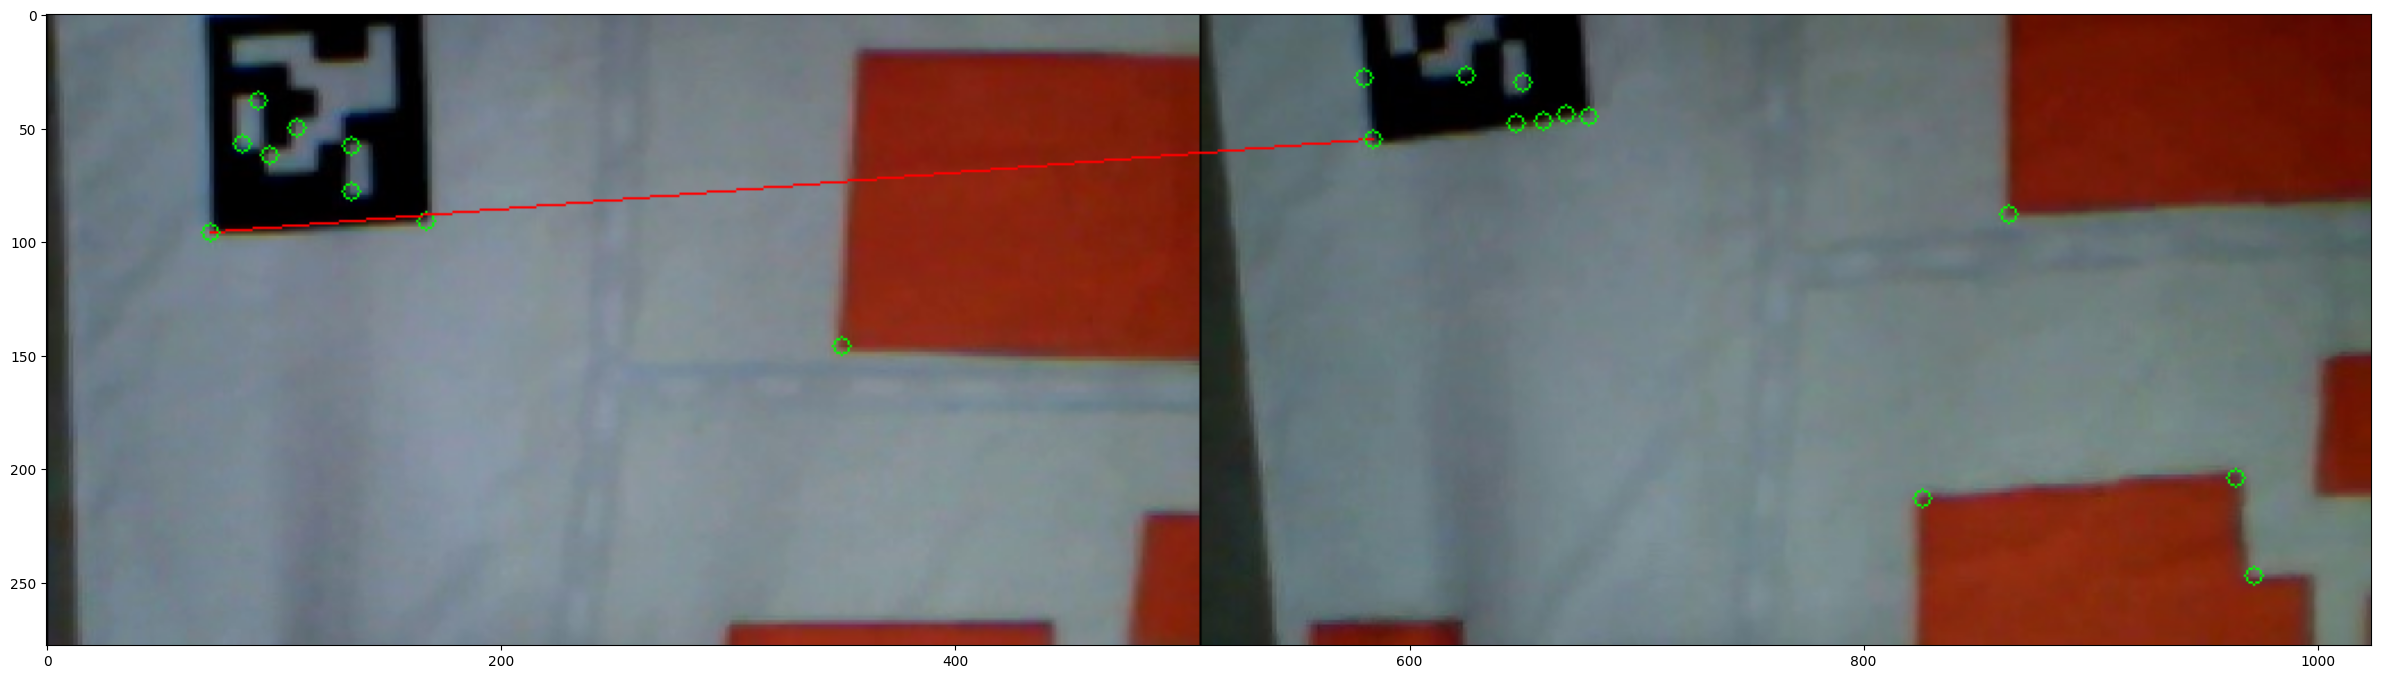

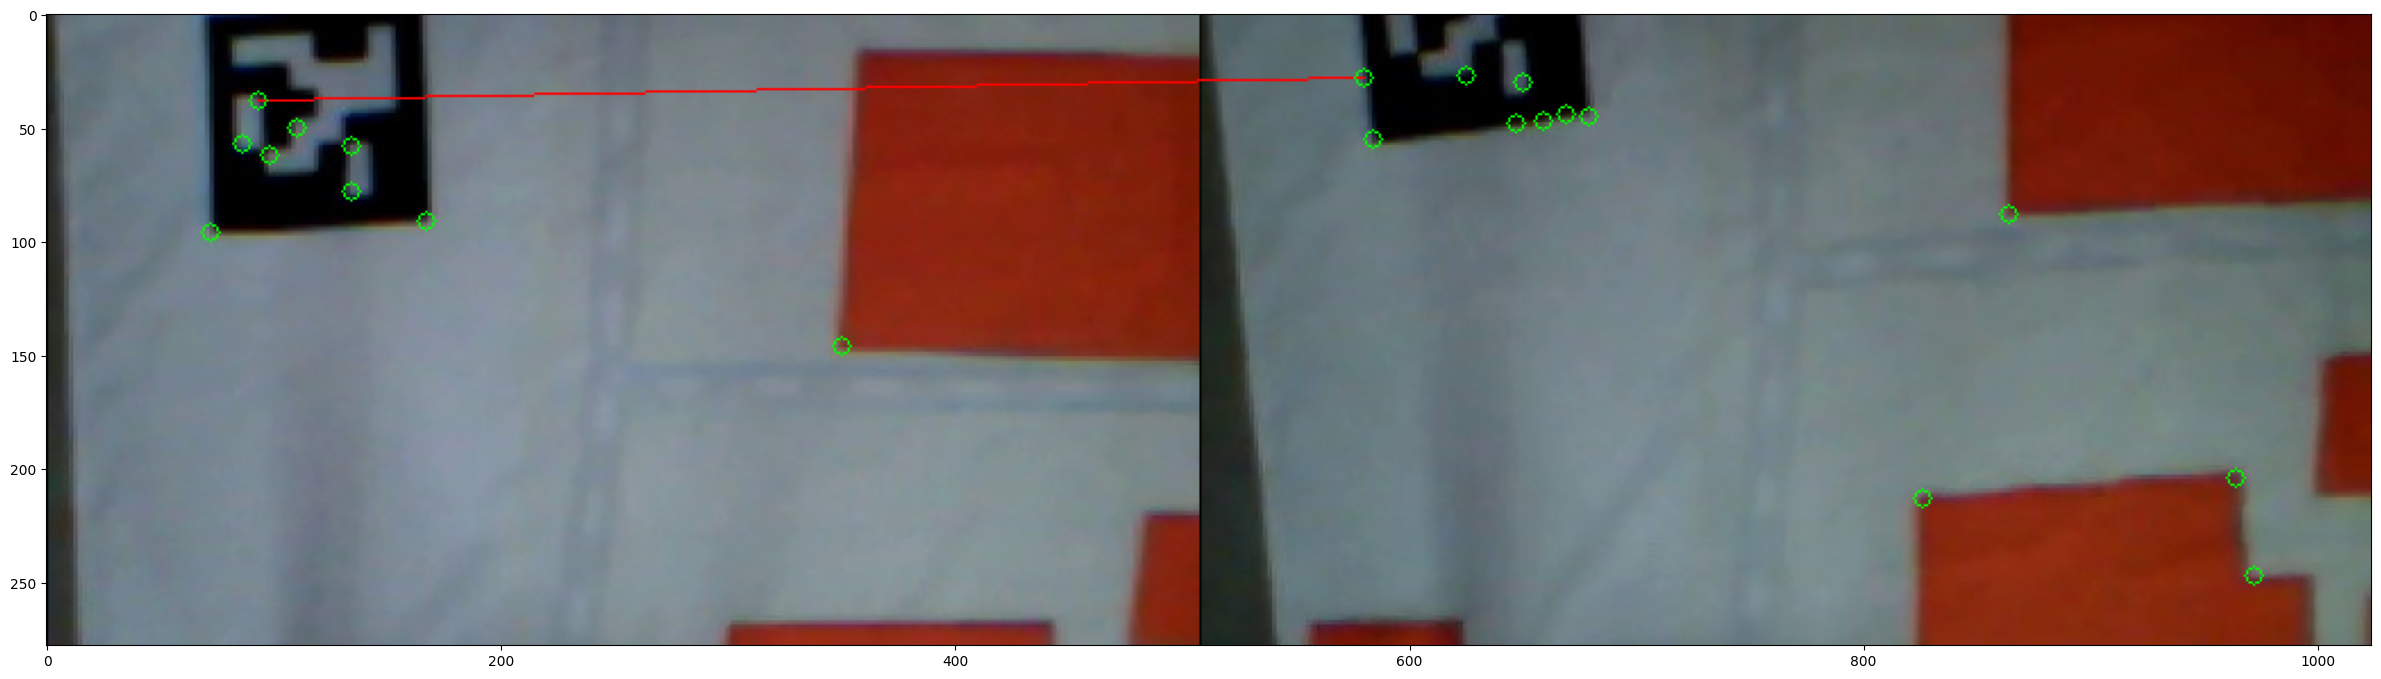

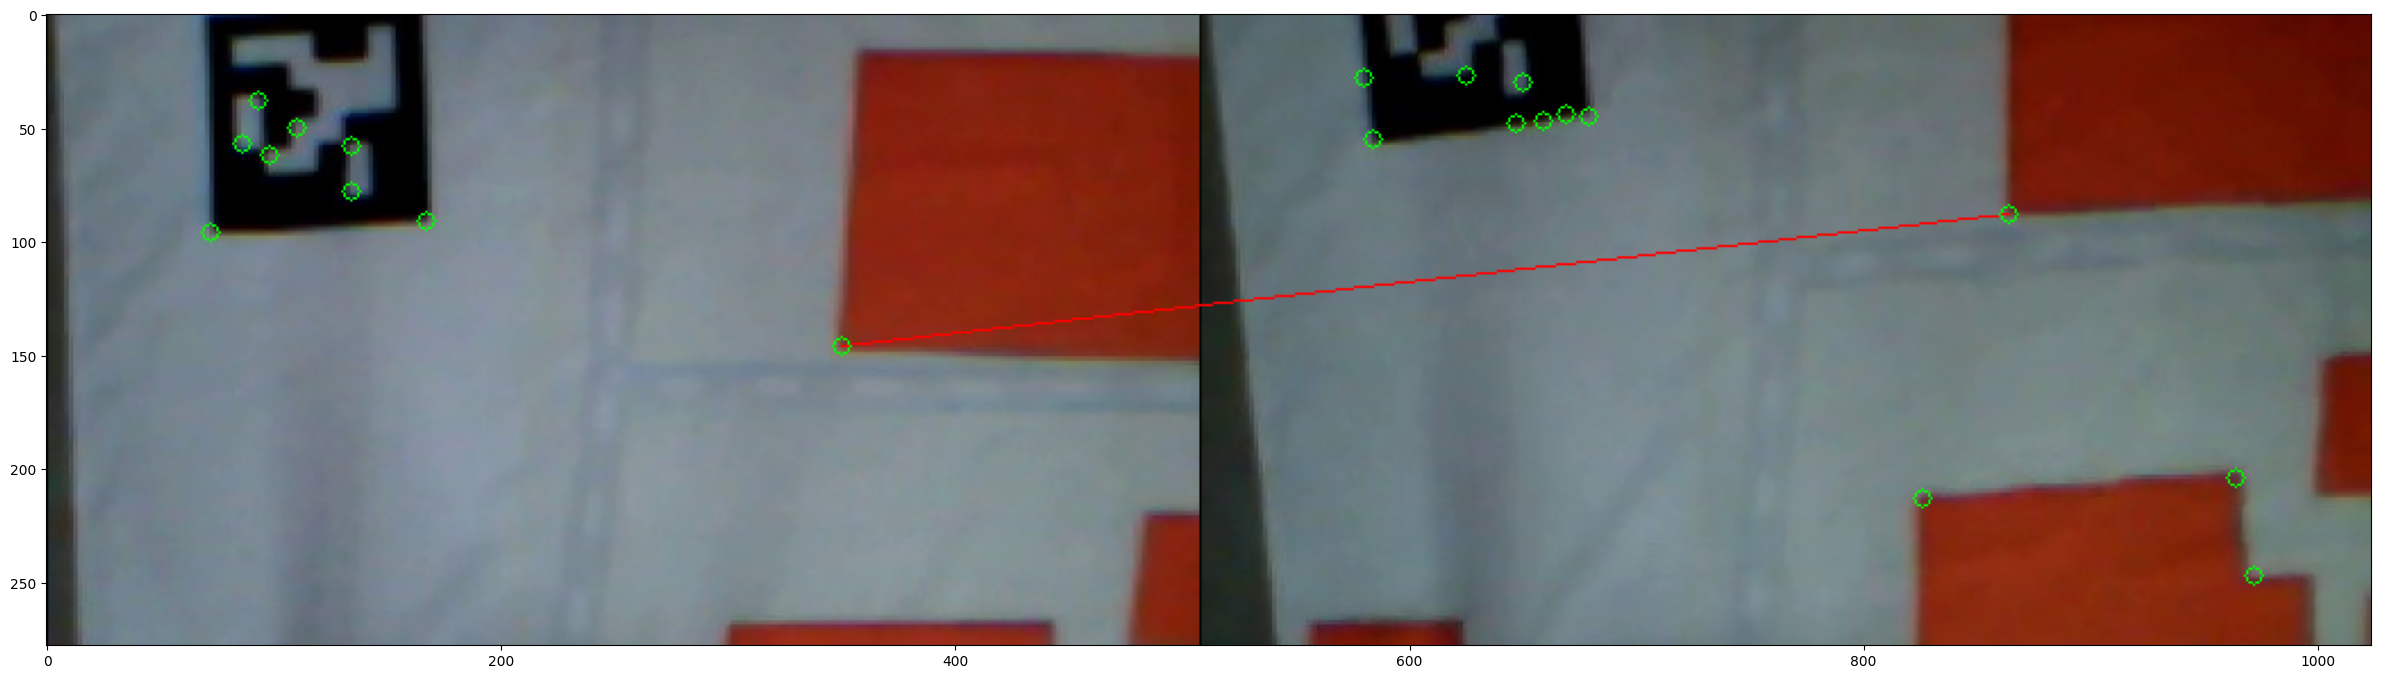

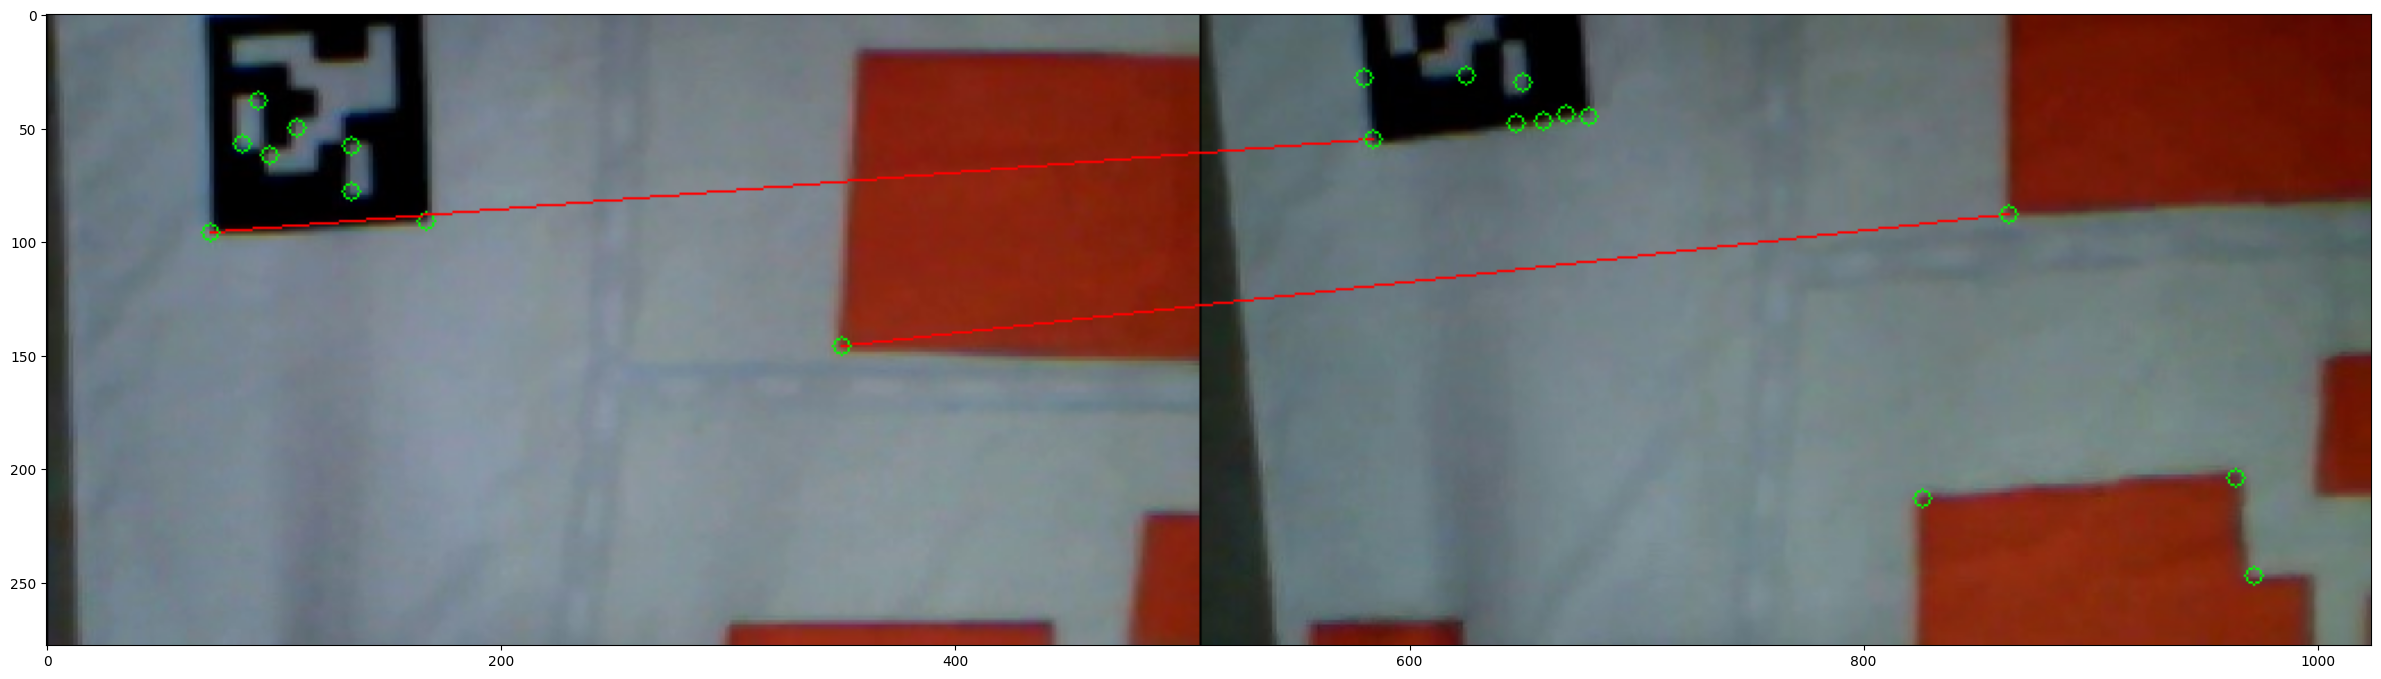

In [13]:
# Insert Image
image_paths = glob.glob('AmbilData2\*.jpg')
imgs = []
n = len(image_paths)

# Kernel Pre-Processing
kernel_contras = np.array([[-1, -1, -1],
                [-1, 9, -1],
                [-1, -1, -1]])
kernel_sharp = np.array([[0, -1, 0],
                [-1, 5, -1],
                [0, -1, 0]])

# Matriks Kalibrasi Kamera
mtx1 = np.array([[682.84055098,   0.,         308.47833431],
 [  0.,         683.17356074, 184.14295734],
 [  0.,           0.,           1.        ]])
dist1 = np.array([-0.02243873,  0.10428033, -0.00261665, -0.00163101, -0.19535318])
newcameramtx1 = np.array([[680.79500661,   0.,         307.68874874],
 [  0.,         681.03835398, 183.55170193],
 [  0.,           0.,           1.        ]])
roi1 = [1, 1, 638, 278]

# Save Image in Var
for i in range(n):
    img = cv2.imread(image_paths[i])
    # Calibrating
    img = cv2.undistort(img, mtx1, dist1, None, newcameramtx1)
    x, y, w, h = roi1
    img = img[y:y+h, x:x+w]
    # Resizing
    # img = cv2.resize(img,None,fx=1.2,fy=1.2)
    # Rotating
    img = cv2.rotate(img, cv2.ROTATE_180)

    imgs.append(img)

# Pre-Processing Left
pref = imgs[0]
pref_gray = cv2.cvtColor(pref, cv2.COLOR_BGR2GRAY)
pref_pp = cv2.convertScaleAbs(pref_gray, alpha=1.5, beta=7)
pref_pp = cv2.filter2D(pref_pp, -1, kernel_sharp)

# Menyamakan Intensitas
if pref_pp.any() < 40:
    for k in range(pref_pp.shape[0]):
        for l in range(pref_pp.shape[1]):
            if pref_pp[k,l] < 40:
                pref_pp[k,l] = random.randint(100, 120)

# Deklarasi Metode
orb = cv2.ORB_create(nfeatures=30, scaleFactor=1.2, nlevels=3, edgeThreshold=25, firstLevel=0, WTA_K=2, patchSize=31, fastThreshold=20)

# Matriks Transformasi
TM = []

# Loop Feature Detection - Get Transformation Matrix
for i in range(1,2):

    left = pref
    left_gray = pref_gray
    left_pp = pref_pp

    # Pre-Processing Right
    right = imgs[i]
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    right_pp = cv2.convertScaleAbs(right_gray, alpha=1.5, beta=7)
    right_pp = cv2.filter2D(right_pp, -1, kernel_sharp)

    # Menyamakan Intensitas
    if right_pp.any() < 40:
        for k in range(right_pp.shape[0]):
            for l in range(right_pp.shape[1]):
                if right_pp[k,l] < 40:
                    right_pp[k,l] = random.randint(100, 120)


    # Ekstraksi Fitur
    kp_left, des_left = orb.detectAndCompute(left_pp, None)
    kp_right, des_right = orb.detectAndCompute(right_pp, None)

    # Gambar KeyPoint
    # keypoints_drawn_left = cv2.drawKeypoints(left, kp_left, None, color=(0, 255, 0))
    # keypoints_drawn_right = cv2.drawKeypoints(right, kp_right, None, color=(0, 255, 0))
    # plot_images(keypoints_drawn_left, keypoints_drawn_right)

    # Buang Fitur Berdempetan
    kp_l_f = []
    des_l_f = []
    for idx1, kp in enumerate(kp_left):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_l_f)):
            if  jarak((x,y),kp_l_f[idx2])< 10:
                idx2 -= 1
                break
        if idx2 == len(kp_l_f)-1:
            des_l_f.append(des_left[idx1])
            kp_l_f.append((x, y))
    des_l_f = np.array(des_l_f)
    kp_l_f = np.array(kp_l_f).astype(int)
    kp_r_f = []
    des_r_f = []
    for idx1, kp in enumerate(kp_right):
        x, y = kp.pt
        idx2 = -1
        for idx2 in range(len(kp_r_f)):
            if jarak((x,y), kp_r_f[idx2]) < 10:
                idx2 -= 1
                break
        if idx2 == len(kp_r_f)-1:
            des_r_f.append(des_right[idx1,:])
            kp_r_f.append((x, y))
    des_r_f = np.array(des_r_f)
    kp_r_f = np.array(kp_r_f).astype(int)

    # # Buang Fitur di Area Hitam
    # kp_l_fh = []
    # des_l_fh = []
    # for idx1 in range(len(kp_l_f)):
    #     y, x = kp_l_f[idx1]
    #     if left_pp[x+3,y] > 37 & left_pp[x,y+3] > 37 & left_pp[x-3,y] > 37 & left_pp[x,y-3] > 37:
    #         kp_l_fh.append((x,y))
    #         des_l_fh.append(des_l_f[idx1,:])
    # des_l_f = np.array(des_l_fh)
    # kp_l_f = np.array(kp_l_fh)
    # kp_r_fh = []
    # des_r_fh = []
    # for idx1 in range(len(kp_r_f)):
    #     y, x = kp_r_f[idx1]
    #     if right_pp[x+3,y] > 37 & right_pp[x,y+3] > 37 & right_pp[x-3,y] > 37 & right_pp[x,y-3] > 37:
    #         kp_r_fh.append((x,y))
    #         des_r_fh.append(des_r_f[idx1,:])
    # des_r_f = np.array(des_r_fh)
    # kp_r_f = np.array(kp_r_fh)

    # Gambar Filtered KeyPoint
    left_draw_kp = left
    right_draw_kp = right
    for point in kp_l_f:
        cv2.circle(left_draw_kp, point, 4, (0,255,0))
    for point in kp_r_f:
        cv2.circle(right_draw_kp, point, 4, (0,255,0))
    # lr_draw_kp = cv2.addWeighted(left_draw_kp, 0.5, right_draw_kp, 0.5, 0)
    plot_images(left_draw_kp,right_draw_kp)

    # Pencocokan Fitur
    pt_mat = []
    dis_mat = []
    for idx1 in range(len(kp_l_f)):
        xl, yl = kp_l_f[idx1]
        idx_mat = []
        for idx2 in range(len(kp_r_f)):
            xr, yr = kp_r_f[idx2]
            if jarak((xr,yr),(xl,yl)) < 100:
                idx_mat.append(idx2)
        d_best = float('inf')
        for idx2 in idx_mat:
            d = hamming_distance(des_l_f[idx1], des_r_f[idx2])
            # Matching
            if d < d_best:
                d_best = d
                idx = idx2
        if d_best < 31:
            pt_mat.append((kp_l_f[idx1][0],kp_l_f[idx1][1],kp_r_f[idx][0],kp_r_f[idx][1]))
            dis_mat.append(d_best)
            
    # Gambar Matches
    for k in range(len(pt_mat)):
        img_con = np.concatenate((left, right), axis=1)
        for x1, y1, x2, y2 in pt_mat[k:k+1]:
            cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
            cv2.circle(img_con, (x1, y1), 4, (0,255,0))
            cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
        plot_images(img_con)

    img_con = np.concatenate((left, right), axis=1)
    dis_pos = []
    for x1, y1, x2, y2 in pt_mat:
        dis_pos.append(jarak((x1,y1), (x2,y2)))
    #     cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
    #     cv2.circle(img_con, (x1, y1), 4, (0,255,0))
    #     cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    # plot_images(img_con)


    # Miss Match Removing - Berdasarkan Jarak
    rounded_dis_pos = [round(num, -1) for num in dis_pos]
    # print(pt_mat)
    print(rounded_dis_pos)
    modus = statistics.mode(rounded_dis_pos)
    pt_mat_df = []
    dis_mat_df = []
    for k in range(len(pt_mat)):
        if rounded_dis_pos[k] == modus:
            pt_mat_df.append(pt_mat[k])
            dis_mat_df.append(dis_mat[k])
    if len(pt_mat_df) < 2:
        pt_mat_df = pt_mat
        dis_mat_df = dis_mat
    # print(pt_mat_df)
    # print(dis_mat_df)

    # Miss Match Removing - Berdasarkan Hamming Distance
    sorted_combined = sorted(zip(dis_mat_df, pt_mat_df))
    limit = 2
    sorted_dis, sorted_pt = zip(*sorted_combined[:limit])
    # print(sorted_pt)
    # print(sorted_dis)

    # Gambar Best Matches
    img_con = np.concatenate((left, right), axis=1)
    for x1, y1, x2, y2 in sorted_pt:
        cv2.line(img_con, (x1, y1), (x2+left.shape[1], y2), (0, 0, 255), 1)
        cv2.circle(img_con, (x1, y1), 4, (0,255,0))
        cv2.circle(img_con, (x2+left.shape[1], y2), 4, (0,255,0))
    plot_images(img_con)

    # Cari Matriks Transformasi
    # Translasi
    x1, y1, x2, y2 = sorted_pt[0]
    tx = x1 - x2
    ty = y1 - y2
    T1 = np.array([[1, 0, tx],
               [0, 1, ty],
               [0, 0, 1]])
    # Rotasi
    x3, y3, x4, y4 = sorted_pt[1]
    v1 = (x3-x1, y3-y1)
    v2 = (x4-x2, y4-y2)
    dot_product = np.dot(v1, v2)
    norm_a = np.linalg.norm(v1)
    norm_b = np.linalg.norm(v2)
    angle_radians = np.arccos(dot_product / (norm_a * norm_b))
    theta = np.degrees(angle_radians) # Dalam derajat 
    # print(theta)
    if theta < 5:
        theta = 0 
    center = (x2,y2)
    T2 = cv2.getRotationMatrix2D((float(x1),float(y1)), theta, 1)
    # T2 = np.append(T2, [0, 0, 1])
    M = np.dot(T2,T1)
    # print(T2)
    # print(M)

    # Simpan Matriks Transformasi
    if i == 1:
        TM.append(M)
        TM = np.array(TM)
    else:
        M1 = np.vstack((TM[i-2], [0, 0, 1]))
        M = np.dot(M,M1)
        TM = np.append(TM, [M], axis=0)
    # print(TM)

    # Simpan Gambar Kanan Untuk Kiri
    pref = right
    pref_gray = right_gray
    pref_pp = right_pp

# Loop Image Registration
pref = imgs[0]
for i in range(1,1):
    left = pref
    right = imgs[i]
    dim_x = left.shape[1] + right.shape[1]
    dim_y = left.shape[0] + right.shape[0]
    dim = (dim_x, dim_y)
    comb = cv2.warpAffine(right,TM[i-1],dim)
    # comb = cv2.addWeighted(left, 1, comb, 0.5, 0)
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    left_gray = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
    right_gray = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)
    for k in range(left.shape[0]):
        for l in range(left.shape[1]):
            if comb_gray[k,l] < left_gray[k,l]:
                comb[k,l] = left[k,l]
                # if comb_gray[k,l] > 0:
                #     comb[k,l] = int((left[k,l]+comb[k,l])/2)
                # else:                    
                #     comb[k,l] = left[k,l]
    plot_images(comb)
    # Crop
    comb_gray = cv2.cvtColor(comb, cv2.COLOR_BGR2GRAY)
    for j in range(int(dim_x/2),dim_x):
        if comb_gray[:,j].sum() == 0:
            x_crop = j
            break
        else:
            x_crop = dim_x
    for j in range(int(dim_y/2),dim_y):
        if comb_gray[j,:].sum() == 0:
            y_crop = j
            break
        else:
            y_crop = dim_y
    if y_crop == dim_y | x_crop == dim_x:
        print("Penjahitan Error!")
        break
    pref = comb[:y_crop, :x_crop]
    plot_images(pref)


    # bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # matches = bf.match(des_l_f,des_r_f)

    # limit = 2
    # best = sorted(matches, key = lambda x:x.distance)[:limit]

    # matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, matches, None, matchColor=(0,0,255), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # plot_images(matches_drawn)

    # best_matches_drawn = cv2.drawMatches(left, kp_left, right, kp_right, best, None, matchColor=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # plot_images(best_matches_drawn)

    # left_pts = []
    # right_pts = []
    # for m in best:
    #     l = kp_left[m.queryIdx].pt
    #     r = kp_right[m.trainIdx].pt
    #     left_pts.append(l)
    #     right_pts.append(r)

    # M, _ = cv2.findHomography(np.float32(right_pts), np.float32(left_pts))

    # dim_x = left.shape[1] + right.shape[1]
    # dim_y = left.shape[0] + right.shape[0]
    # dim = (dim_x, dim_y)

    # warped = cv2.warpPerspective(right, M, dim)

    # # plot_images(warped)

    # comb = warped.copy()
    # # combine the two images
    

In [7]:
# for i in range(100):
    # print('{:06d}'.format(i))
